In [1]:
import torch
from model.encoder import Encoder
from model.self_interaction import SelfInteraction
from model.cross_interaction import CrossInteraction
from model.guided_backprop import GuidedBackprop
from PIL import Image
import PIL
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
plt.rcParams['figure.figsize'] = (15.0, 15.0)

In [6]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def rescale_grads(map,gradtype="all"):
    if(gradtype=="pos"):    
        map = (np.maximum(0, map) / map.max())
    elif gradtype=="neg":
        map = (np.maximum(0, -map) / -map.min())
    else:
        map = map - map.min()
        map /= map.max()
    return map

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr * 255).astype(np.uint8)
    return np_arr

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)
    
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale

    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 95)
#     im_max=np.max(grayscale_im)
    im_min = np.min(grayscale_im)
    grayscale_im=(grayscale_im - im_min) / (im_max - im_min)
#     grayscale_im = np.clip(grayscale_im, 0, 1)
#     grayscale_im-=np.min(grayscale_im)
    grayscale_im=grayscale_im/np.max(grayscale_im)

    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    grayscale_im=np.repeat(grayscale_im,3,axis=0)*255
    return grayscale_im

def convert_to_rgb(img_as_arr):
    img=img_as_arr-img_as_arr.min()
    img/=img.max()
    img=img*256
    return img

def invert_sk(sk):
    sk=sk.split()[0]
    sk=PIL.ImageOps.invert(sk)
    sk=Image.merge('RGB', (sk, sk, sk))
    return sk

def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('./visualization'):
        os.makedirs('./visualization')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('./visualization', file_name + '.jpg')
    save_image(gradient, path_to_file)

In [7]:
ckpt_path='/home/xjq/code/shoe/DLI-Net/ckpt/dli-shoe-v2.pth'
img_encoder=Encoder('mid').cuda()
sk_encoder=Encoder('mid').cuda()
ckpt=torch.load(ckpt_path)
img_encoder.load_state_dict(ckpt['encoder_img'])
sk_encoder.load_state_dict(ckpt['encoder_sk'])
self_interaction=SelfInteraction(0.5)
match=CrossInteraction('2norm')
guided_back=GuidedBackprop(img_encoder,sk_encoder,self_interaction,match)

In [8]:
img_path='/home/xjq/code/dataset/qmul_v2/ShoeV2/trainB/1050000078.png'
sk_path='/home/xjq/code/dataset/qmul_v2/ShoeV2/trainA/1050000078_2.png'
norm=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
input_transform=transforms.Compose([transforms.Resize(256),transforms.ToTensor(), norm])
img=Image.open(img_path)
img_tensor=input_transform(img)
img_tensor=img_tensor.unsqueeze(0).cuda()
sk=Image.open(sk_path)
sk = sk.split()[3]
sk = Image.merge('RGB', (sk, sk, sk))
sk_tensor = input_transform(sk)
sk_tensor=sk_tensor.unsqueeze(0).cuda()
img_tensor.requires_grad=True
sk_tensor.requires_grad=True

/usr/local/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(-0.5, 255.5, 255.5, -0.5)

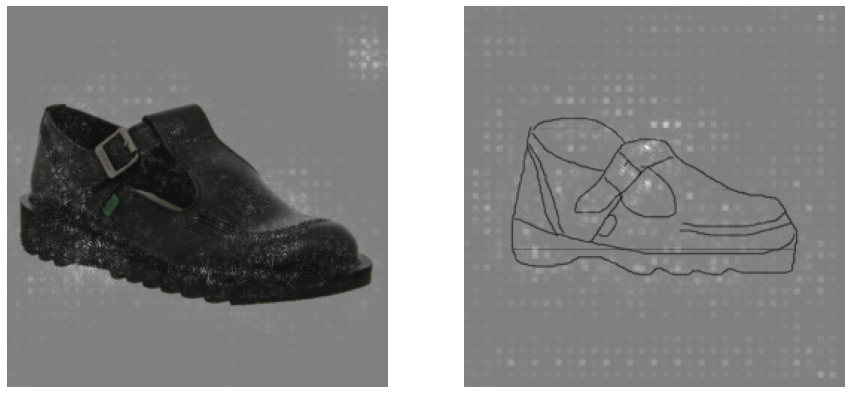

In [9]:
img_grad,sk_grad=guided_back.generate_gradients(img_tensor,sk_tensor)
grayscale_img_grads = convert_to_grayscale(img_grad).transpose(1,2,0)
grayscale_sk_grads = convert_to_grayscale(sk_grad).transpose(1,2,0)
# grayscale_img_grads = convert_to_rgb(img_gradients).transpose(1,2,0)
# grayscale_sk_grads = convert_to_rgb(sk_gradients).transpose(1,2,0)
# conver original img
# img=img.resize((256,256))
# sk=sk.resize((256,256))
# img=np.array(grayscale_img_grads).transpose(2, 1, 0)
# sk=np.array(grayscale_sk_grads).transpose(2, 1, 0)
img=img.resize((256,256))
sk=invert_sk(sk)
sk=sk.resize((256,256))
back_img=np.array(img)*0.5+grayscale_img_grads*0.5
back_sk=np.array(sk)*0.5+grayscale_sk_grads*0.5
back_img=np.clip(back_img,0,255)
back_sk=np.clip(back_sk,0,255)

back_img=np.uint8(back_img)
back_sk=np.uint8(back_sk)
plt.subplot(1, 2, 1)    
plt.imshow(back_img)
plt.axis('off')
plt.subplot(1, 2, 2) 
plt.imshow(back_sk)
plt.axis('off')